**Here I will consider only tdsfog, I will look at the balance of the two binary components of the target trait. I will also combine them with the available information about the subjects of the study and draw conclusions about their impact on features.**

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, average_precision_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

warnings.simplefilter(action='ignore')

In [3]:
all_df=[]
for file in path.glob('*.csv'):
    df = pd.read_csv(file, index_col=[0])
    df['Id'] = file.name
    all_df.append(df)

In [4]:
data = pd.DataFrame()
for x in all_df:
    data = pd.concat([data, x])

In [5]:
data.Id = data.Id.str.replace('.csv', '')

The ratio of positive and negative reactions in the target


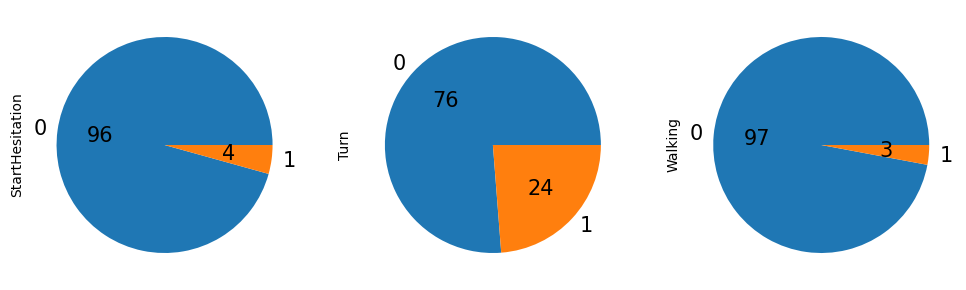

In [6]:
print('The ratio of positive and negative reactions in the target')
fig, axs = plt.subplots(ncols=3, figsize=(10, 3))
autopct='%.0f'
font_size=15
data.StartHesitation.value_counts().plot.pie(autopct=autopct,fontsize=font_size, ax=axs[0])
data.Turn.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[1])
data.Walking.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[2])
fig.tight_layout()

In [8]:
metadata.Medication = np.where(metadata.Medication=='on', 1, 0)

In [10]:
subject = subject.drop('Visit', axis=1)
subject.UPDRSIII_On = subject.UPDRSIII_On.fillna(subject.UPDRSIII_On.median())
subject.UPDRSIII_Off = subject.UPDRSIII_Off.fillna(subject.UPDRSIII_Off.median())
subject.Sex = np.where(subject.Sex=='M', 1, 0)

In [11]:
data_id = metadata.merge(subject, on='Subject')
data_td = data.merge(data_id, on='Id')

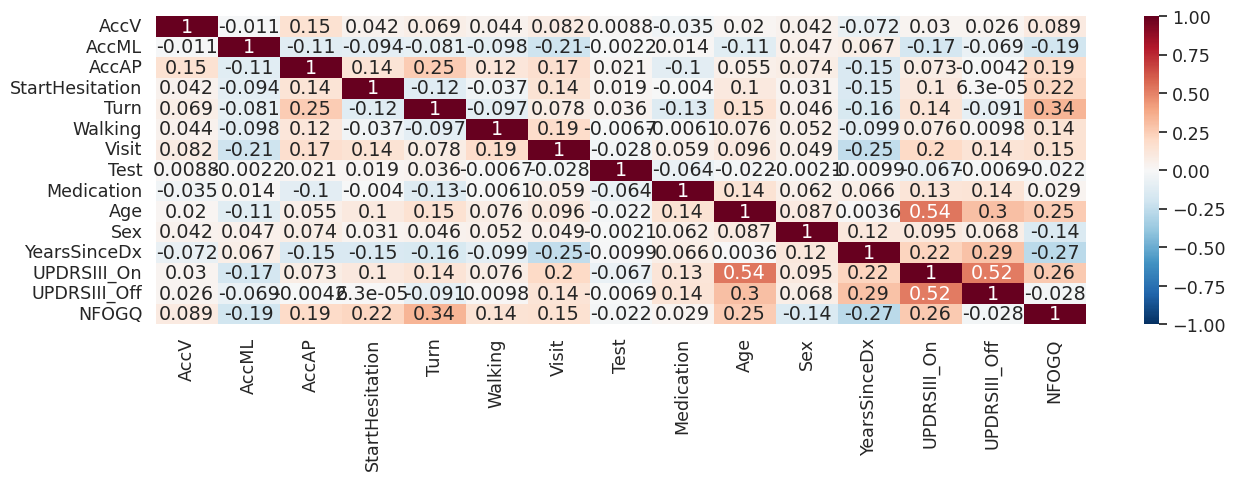

In [12]:
sns.set(font_scale=1.15)
plt.figure(figsize=(15,4))
sns.heatmap(
    data_td.corr(),        
    cmap='RdBu_r', 
    annot=True,
    vmin=-1, vmax=1);

We need to determine which features of (AccV, AccML, AccAP) have the greatest impact on the appearance of a positive reaction in the signs of StartHesitation, Turn, Walking, but to clarify the issue, we will consider the effect of other features on these parameters (+ - positive correlation b - - negative ).
Based on the heat map, we will select the features that have the greatest impact on the parameters under study and also see what affects them:
* on StartHesitation:
   +NFOGO(+)
   + YearsSinceDx(-)
   + AccAP(+)
   +Visit(+)
* on Turn:
   +NFOGO(+)
   + AccAP(+)
   + YearsSinceDx(-)
   + age
   +UPDRSIII_On(+)
   + Medication(-)
* on Walking:
   +Visit(+)
   +NFOGO(+)
   + AccAP(+)

Now let's see what has the biggest impact on (AccV, AccML, AccAP):
* on AccV:
   + AccAP(+)
* on AccML:
   +Visit(-)
   +NFOGO(-)
   + UPDRSIII_On(-)
* on AccAP:
   +NFOGO(+)
   +Visit(+)
   + YearsSinceDx(-)

Conclusions:
- the main problem is the imbalance of the predicted classes, a positive class appears extremely rarely;
- it is necessary to study all the available data in more detail, determine the degree of their influence on the features, and then assign each of the features its own weight when training the models.

In [13]:
random.seed(42)

In [14]:
X = data_td[['AccV', 'AccML', 'AccAP']]
start = data.StartHesitation
turn = data.Turn
walk = data.Walking

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, start, stratify=start,
                                                      test_size=0.2)

In [16]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_valid)
print(accuracy_score(y_valid, pred_lr))
print(precision_score(y_valid, pred_lr))

0.9565759432509637
0.025


We see that with excellent indicators of overall accuracy, the level of predicting the precision of the positive class is extremely low.
I tried to increase the level of precision of the positive reaction of the target by applying several classification models, it takes a very long time and the maximum that I could achieve was 0.6 And this is not much! And then I saw that there are very close relationships between all the features in the training sample, and what if we try to solve this classification problem using regression.


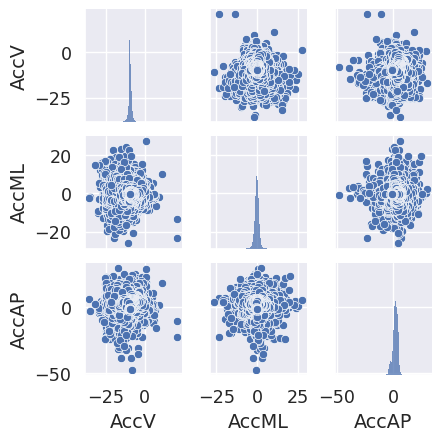

In [17]:
sns.pairplot(X, height=1.5, aspect=1);

Let's try to use the Random Forest model in regression and look at the resulting evaluation metric, such as MAE.

In [18]:
rf = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
preds_start = rf.predict(X_valid)
print('MAE: ', mean_absolute_error(y_valid, preds_start).round(3))

MAE:  0.076


Predictions of the Random Forest model in regression by target - StartHesitation


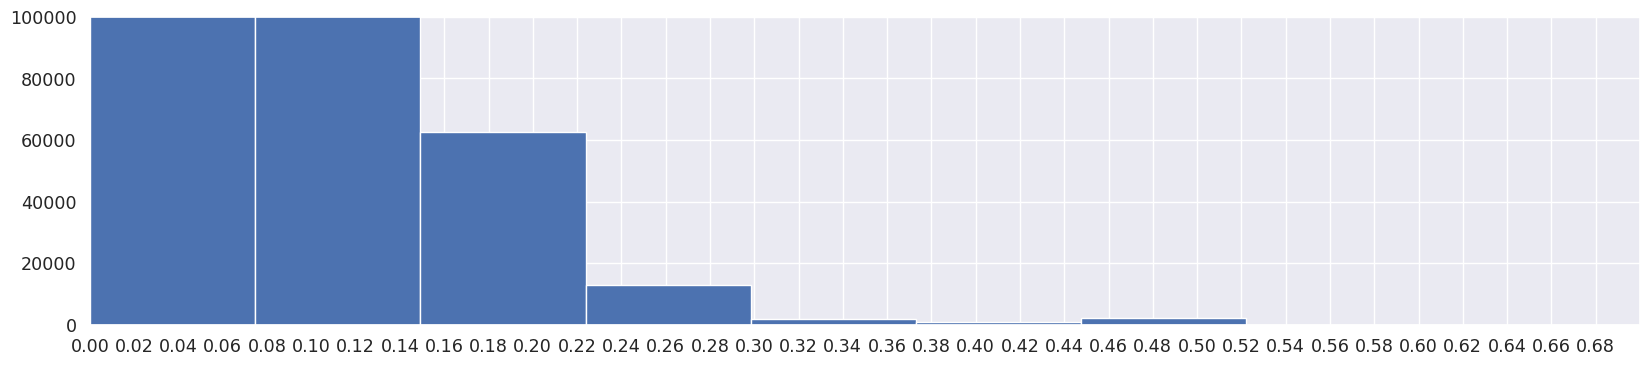

In [19]:
print('Predictions of the Random Forest model in regression by target - StartHesitation')
plt.figure(figsize=(20, 4))
plt.xlim(0, 0.7)
plt.ylim(0, 100000)
plt.xticks(np.arange(0, 0.7, step=0.02))
plt.hist(x=pd.Series(preds_start))
plt.show()

And now let's try to classify the received predictions and apply the precision metric to them.

In [20]:
pred_01 = pd.Series(np.where(preds_start<=0.1, 0, 1))
precision_score(y_valid, pred_01)

0.16047296358269358

It's actually not that bad. In this situation, the most important thing is to choose a significance threshold for the predictions of the regression model. For this I wrote a function.

In [21]:
def binar(pred):
    thresholds = np.arange(0, 1, step=0.2)
    best_precision = 0
    best_threshold = 0
    for threshold in thresholds:
        prediction = pd.Series(np.where(pred < threshold, 0, 1))
        precision = average_precision_score(y_valid, prediction)
        if precision > best_precision:
            best_precision = precision
            best_threshold = threshold
    return best_precision, best_threshold

And now I have already exceeded the metric obtained for many hours of the classification model, spending a couple of minutes on this)
Now I will do the same for the other two targets.

In [22]:
print('Average_precision for start: ',  binar(preds_start)[0])

Average_precision for start:  0.0729335013294908


In [23]:
threshold_start = binar(preds_start)[1]

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, turn, stratify=turn,
                                                      test_size=0.2)

In [25]:
rf = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
preds_turn = rf.predict(X_valid)
print('MAE: ', mean_absolute_error(y_valid, preds_turn).round(3))

MAE:  0.305


Predictions of the Random Forest model in regression by target - Turn


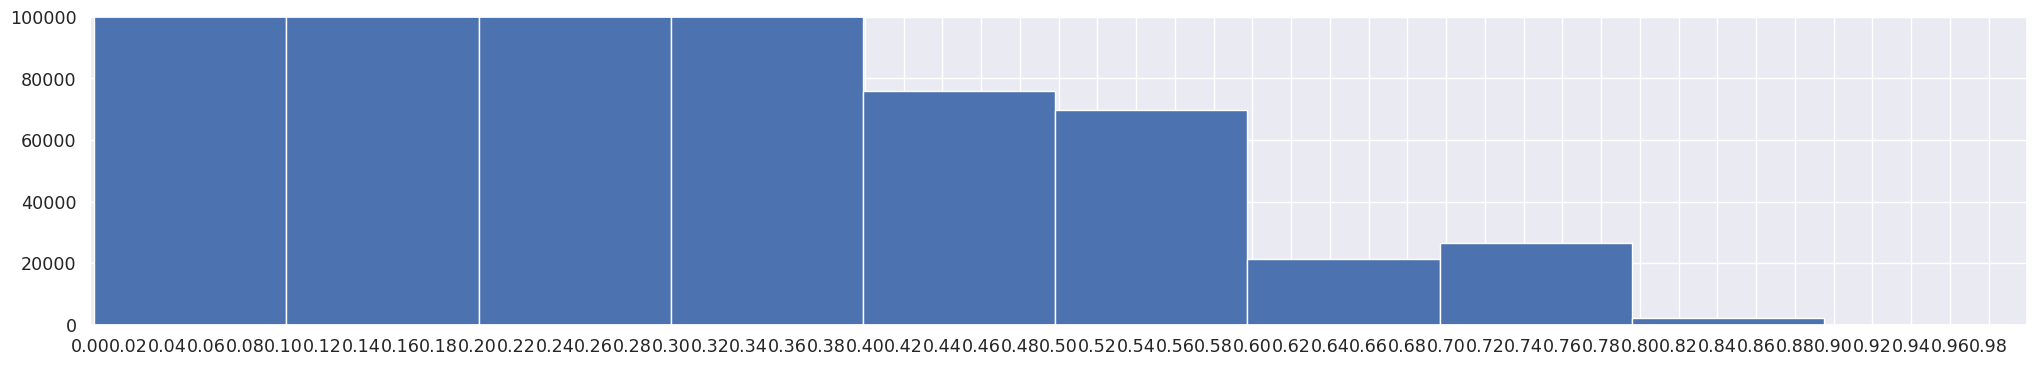

In [26]:
print('Predictions of the Random Forest model in regression by target - Turn')
plt.figure(figsize=(25, 4))
plt.xlim(0, 1)
plt.ylim(0, 100000)
plt.xticks(np.arange(0, 1, step=0.02))
plt.hist(x=pd.Series(preds_turn))
plt.show()

In [27]:
print('Average_precision for turn: ',  binar(preds_turn)[0])

Average_precision for turn:  0.3396759737379246


In [28]:
threshold_turn = binar(preds_turn)[1]

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, walk, stratify=walk,
                                                      test_size=0.2)

In [30]:
rf = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
preds_walk = rf.predict(X_valid)
print('MAE: ', mean_absolute_error(y_valid, preds_walk).round(3))

MAE:  0.054


Predictions of the Random Forest model in regression by target - Walking


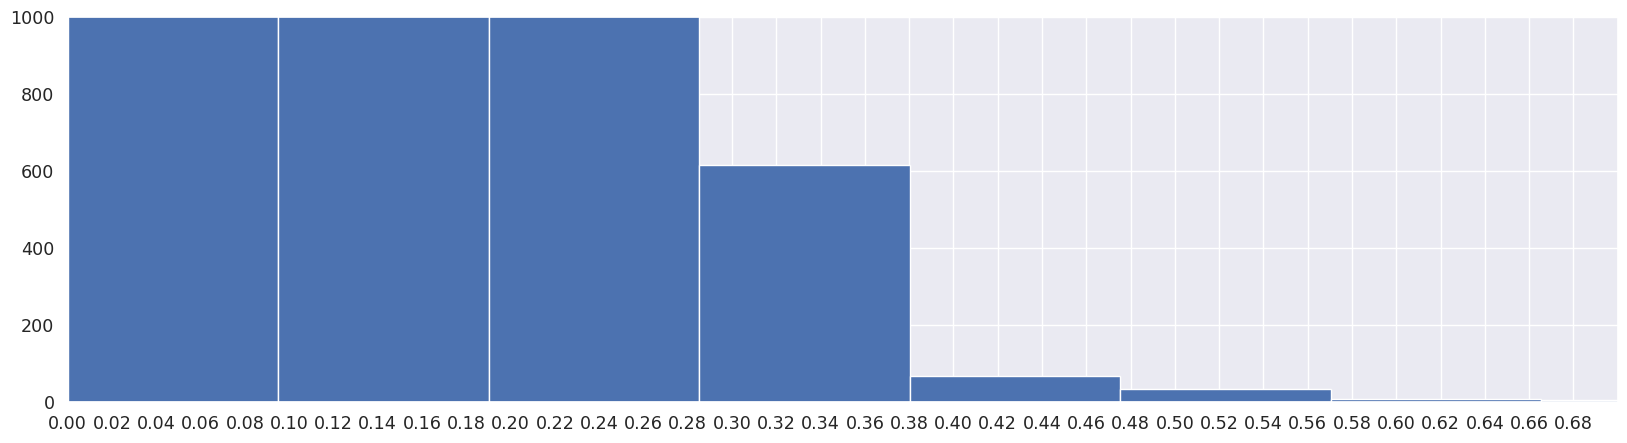

In [31]:
print('Predictions of the Random Forest model in regression by target - Walking')
plt.figure(figsize=(20, 5))
plt.xlim(0, 0.7)
plt.ylim(0, 1000)
plt.xticks(np.arange(0, 0.7, step=0.02))
plt.hist(x=pd.Series(preds_walk))
plt.show()

In [32]:
print('Average_precision for walk: ',  binar(preds_walk)[0])

Average_precision for walk:  0.04973452625483146


In [33]:
threshold_walk = binar(preds_walk)[1]

In total, we have that by setting the exact threshold of significance for classifying the predictions of the regression model, we may well achieve good performance for the metric we need.

Now let's move on to testing:

In [35]:
X = data[['AccV', 'AccML', 'AccAP']]
start = data.StartHesitation
turn = data.Turn
walk = data.Walking

In [36]:
rf = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=42)
rf.fit(X, start)
preds_start = rf.predict(X_test)

In [37]:
prediction_start = pd.Series(np.where(preds_start < threshold_start, 0, 1))

In [38]:
rf = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=42)
rf.fit(X, turn)
preds_turn = rf.predict(X_test)

In [39]:
prediction_turn = pd.Series(np.where(preds_turn < threshold_turn, 0, 1))

In [40]:
rf = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=42)
rf.fit(X, walk)
preds_walk = rf.predict(X_test)

In [41]:
prediction_walk = pd.Series(np.where(preds_walk < threshold_walk, 0, 1))

In [43]:
time_index = time_index.Time

In [44]:
predictions_td = pd.concat([time_index, prediction_start, prediction_turn,
                         prediction_walk], axis=1)
predictions_td = predictions_td.rename(columns={'Time': 'Id', 0: 'StartHesitation',
                                          1: 'Turn', 2: 'Walking'})
predictions_td.Id = '003f117e14_' + predictions_td.Id.astype(str)

I realized that I still have time to look at the defog data, I will do it!

In [46]:
all_df=[]
for file in path.glob('*.csv'):
    df = pd.read_csv(file, index_col=[0])
    df['Id'] = file.name
    all_df.append(df)
data_all = pd.DataFrame()
for x in all_df:
    data_all = pd.concat([data_all, x])

In [47]:
data_all.Id = data_all.Id.str.replace('.csv', '')
data_all.Valid = np.where(data_all.Valid == False, 0, 1)
data_all.Task = np.where(data_all.Task == False, 0, 1)

Part of the data here is not validated, let's look at the ratio of all the data and this part. We also compare the number of features of interest to us.

In [48]:
data = pd.DataFrame(data_all.query('Valid==1 and Task==1'))
data = data.drop(['Valid', 'Task'], axis=1)

In [49]:
(data.shape[0]/data_all.shape[0]).__round__(2)

0.3

The ratio of positive and negative reactions in the target (top - validated data / bottom - all data)


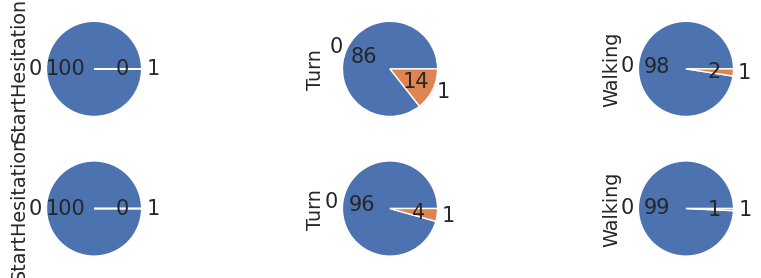

In [50]:
print('The ratio of positive and negative reactions in the target (top - validated data / bottom - all data)')
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(10, 3))
autopct='%.0f'
font_size=15
data.StartHesitation.value_counts().plot.pie(autopct=autopct,fontsize=font_size, ax=axs[0, 0])
data.Turn.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[0, 1])
data.Walking.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[0, 2])
data_all.StartHesitation.value_counts().plot.pie(autopct=autopct,fontsize=font_size, ax=axs[1, 0])
data_all.Turn.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[1, 1])
data_all.Walking.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[1, 2])
fig.tight_layout()

The ratio of the non-validated part to the total is 0.3, we also see that the StartHesitation feature is 0 in both cases, so it makes no sense to work with it in our regression problem) In a valid sample, the Turn feature in a positive binary response is represented more than in the entire dataset . I decided to work only with a valid sample.
Also, I will not combine this dataset with classifying features from other data, since I will also solve this problem through regression, although there are much more interesting cases for class weighting in this case than in the previous one.

In [51]:
X = data[['AccV', 'AccML', 'AccAP']]
turn = data.Turn
walk = data.Walking

In [52]:
X_train, X_valid, y_train, y_valid = train_test_split(X, turn, stratify=turn,
                                                      test_size=0.2)

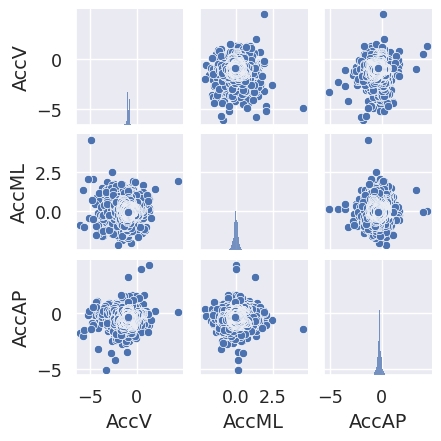

In [53]:
sns.pairplot(X, height=1.5, aspect=1);

In [54]:
rf = RandomForestRegressor(n_estimators=20, max_depth=25, random_state=42)
rf.fit(X_train, y_train)
preds_turn = rf.predict(X_valid)
print('MAE: ', mean_absolute_error(y_valid, preds_turn).round(3))

MAE:  0.195


Predictions of the Random Forest model in regression by target - Turn


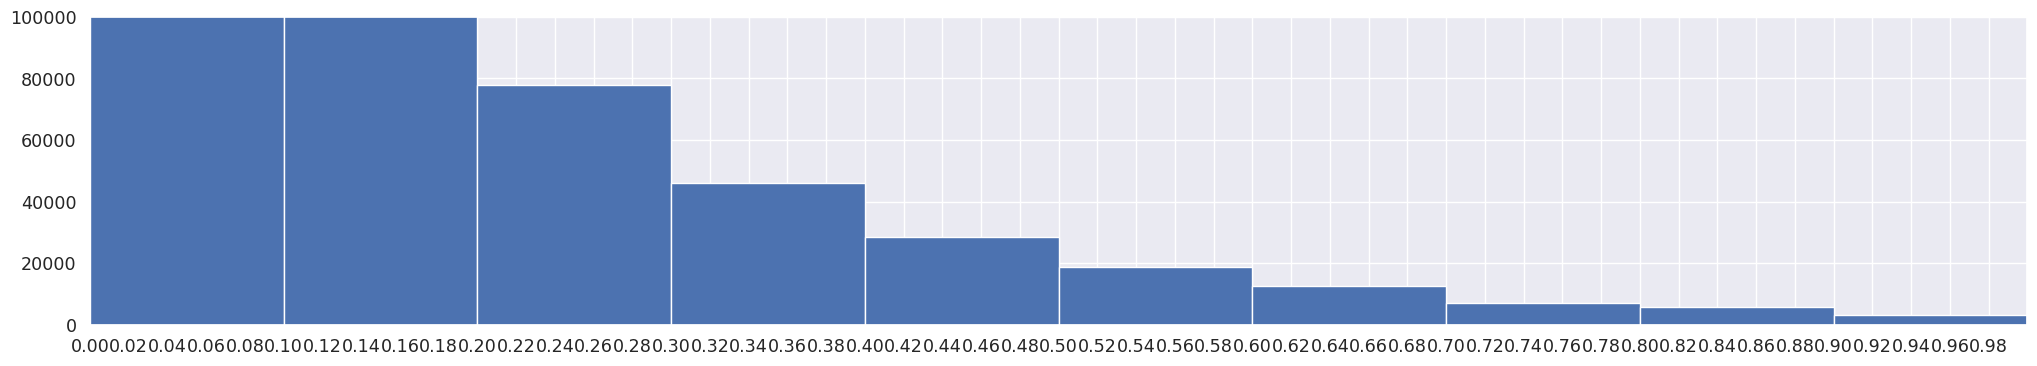

In [55]:
print('Predictions of the Random Forest model in regression by target - Turn')
plt.figure(figsize=(25, 4))
plt.xlim(0, 1)
plt.ylim(0, 100000)
plt.xticks(np.arange(0, 1, step=0.02))
plt.hist(x=preds_turn)
plt.show()

In [56]:
print('Average_precision for turn defog: ', binar(pd.Series(preds_turn))[0])

Average_precision for turn defog:  0.2663778911999664


In [57]:
threshold_turn = binar(pd.Series(preds_turn))[1]

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(X, walk, test_size=0.2,
                                                     stratify=walk)

In [59]:
rf = RandomForestRegressor(n_estimators=20, max_depth=25, random_state=42)
rf.fit(X_train, y_train)
preds_walk = rf.predict(X_valid)
print('MAE: ', mean_absolute_error(y_valid, preds_walk).round(3))

MAE:  0.044


Predictions of the Random Forest model in regression by target - Walking


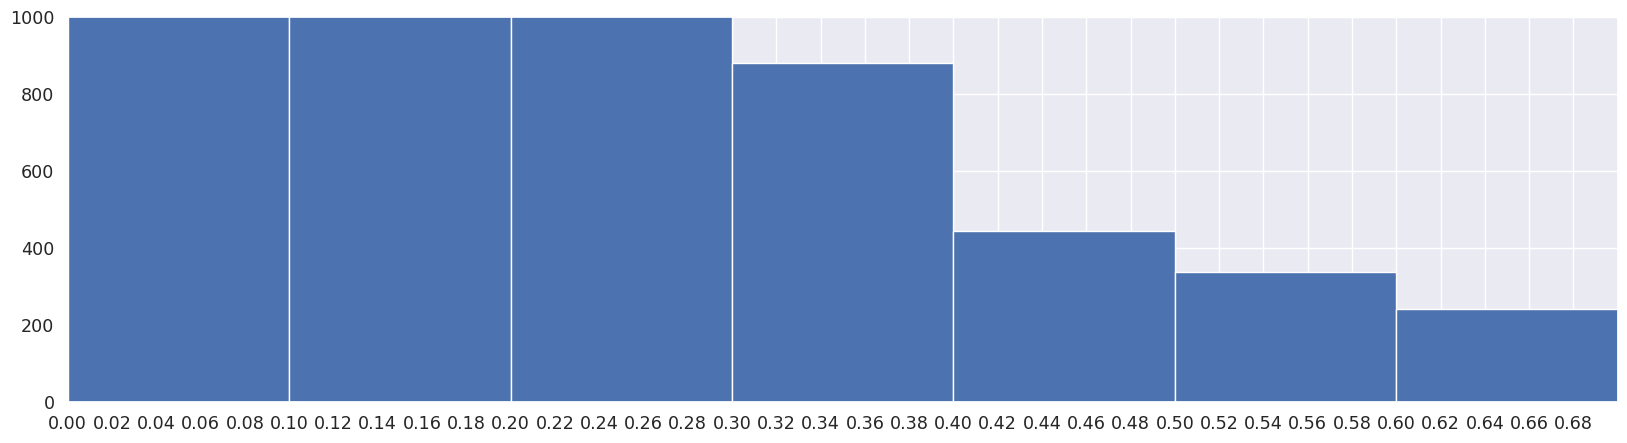

In [60]:
print('Predictions of the Random Forest model in regression by target - Walking')
plt.figure(figsize=(20, 5))
plt.xlim(0, 0.7)
plt.ylim(0, 1000)
plt.xticks(np.arange(0, 0.7, step=0.02))
plt.hist(x=preds_walk)
plt.show()

In [61]:
print('Average_precision for walk defog: ', binar(pd.Series(preds_walk))[0])

Average_precision for walk defog:  0.038011240384809866


In [62]:
threshold_walk = binar(pd.Series(preds_walk))[1]

So I implemented the process of solving the problem of binary classification through regression. It is clear that through careful work with all the available data on the subjects of the study, it is possible to give our features certain weights and predict classes with higher precision metrics, but with my work I wanted to show that one should not focus on only one method of solving problems, but look for what -something new! Well, or because I'm tired of waiting for the classification model to do its job ...